## Start

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats
import yaml
import tqdm


plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
# plt.style.use('ggplot')

In [3]:
all_qs = []
for topic in glob.glob('../questions/topics/*'):
    if 'Demo' not in topic:
        with open(f"{topic}/questions.yaml") as f:
            all_qs.extend(yaml.safe_load(f))

all_qs = pd.DataFrame(all_qs)
correct_answers = dict(zip(all_qs['Id'], all_qs['MultipleChoice'].apply(lambda r: r['Correct'])))

In [4]:
all_user_data = []

for file in glob.glob('../backend/users/*.yaml'):
    if 'demo' not in file:
        with open(file) as f:
            data = yaml.safe_load(f)

        if 'pretest' in data:
            data['pretest'] = pd.DataFrame(data['pretest'])
        if 'questionSchedule' not in data:
            continue
        
        qSchedule = []
        for i, day in enumerate(data['questionSchedule']):
            for j, q in enumerate(day):
                q['day'] = i
                q['numInDay'] = j
                qSchedule.append(q)
        data['questionSchedule'] = pd.DataFrame(qSchedule)

        if 'posttestA' in data:
            data['posttestA'] = pd.DataFrame(data['posttestA'])
        if 'posttestB' in data:
            data['posttestB'] = pd.DataFrame(data['posttestB'])
        if 'sleepData' in data:
            data['sleepData'] = np.array([float(d['numHours']) for d in data['sleepData']])

        all_user_data.append(data)

all_user_data = pd.DataFrame(all_user_data)

In [5]:
# bad_emails = ['madison.evans@som.umaryland.edu', 'puja.patel@som.umaryland.edu', 'kran2@jh.edu', 'charles1@usf.edu']
bad_emails = []
finished_study_data = all_user_data[all_user_data['status'].isin(['posttestDone', 'studyDone', 'posttestPartADone']) & ~all_user_data['email'].isin(bad_emails)]
finished_users = finished_study_data['email'].unique()
print(f"Participants who finished study portion: {len(finished_study_data)}\n{finished_users}")

Participants who finished study portion: 28
['rguilba1@jh.edu' 'csong29@jhmi.edu' 'shamil34@jhmi.edu'
 'logan.kolakowski@som.umaryland.edu' 'shannon.hanggodo@quinnipiac.edu'
 'madison.evans@som.umaryland.edu' 'aweitzn1@jh.edu' 'mkubica1@jhmi.edu'
 'nichole.shaw@som.umaryland.edu' 'psingh34@jh.edu'
 'jfogel@som.umaryland.edu' 'mmarani1@jhmi.edu'
 'lauren.sands@som.umaryland.edu' 'aatkin31@jhmi.edu'
 'puja.patel@som.umaryland.edu' 'slin86@jhmi.edu'
 'robert.liu@som.umaryland.edu' 'pvikram1@jhmi.edu'
 'andrewbharris@jhmi.edu' 'kkuhn14@jh.edu' 'szhan129@jh.edu'
 'maria.novitskaya@som.umaryland.edu' 'kzhu24@jhmi.edu' 'xdai9@jhmi.edu'
 'lyoung1090@gmail.com' 'tzhang1@som.umaryland.edu' 'charles1@usf.edu'
 'kran2@jh.edu']


In [6]:
finished_post_data = all_user_data[all_user_data['status'].isin(['posttestDone']) & ~all_user_data['email'].isin(bad_emails)].reset_index()
print(f"Participants who finished all post-tests: {len(finished_post_data)}\n{finished_post_data['email'].to_list()}")

Participants who finished all post-tests: 27
['rguilba1@jh.edu', 'csong29@jhmi.edu', 'shamil34@jhmi.edu', 'logan.kolakowski@som.umaryland.edu', 'shannon.hanggodo@quinnipiac.edu', 'madison.evans@som.umaryland.edu', 'aweitzn1@jh.edu', 'mkubica1@jhmi.edu', 'nichole.shaw@som.umaryland.edu', 'psingh34@jh.edu', 'jfogel@som.umaryland.edu', 'mmarani1@jhmi.edu', 'lauren.sands@som.umaryland.edu', 'aatkin31@jhmi.edu', 'puja.patel@som.umaryland.edu', 'slin86@jhmi.edu', 'robert.liu@som.umaryland.edu', 'andrewbharris@jhmi.edu', 'kkuhn14@jh.edu', 'szhan129@jh.edu', 'maria.novitskaya@som.umaryland.edu', 'kzhu24@jhmi.edu', 'xdai9@jhmi.edu', 'lyoung1090@gmail.com', 'tzhang1@som.umaryland.edu', 'charles1@usf.edu', 'kran2@jh.edu']


## Fraction contested

Calculating fraction contested overall and per user

In [7]:
with open('../backend/scoring/contestedEvaluations.yaml') as f:
    contested_evaluations = pd.DataFrame(yaml.safe_load(f))

Percentage of overall responses contested: 4.64%


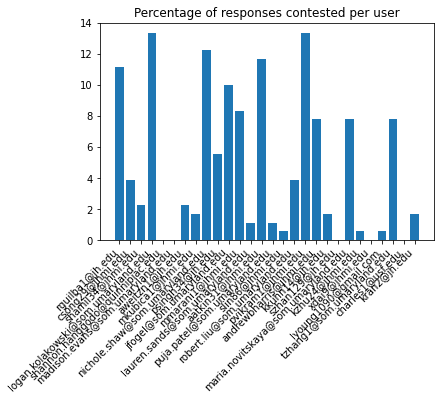

In [8]:
total_questions = 180

frac_contested = len(contested_evaluations[contested_evaluations['user'].isin(finished_users)]) / (len(finished_users) * total_questions)
print(f"Percentage of overall responses contested: {100 * frac_contested:.2f}%")

frac_contested_per_user = {user: (contested_evaluations['user'] == user).sum() / total_questions for user in finished_users}
plt.title('Percentage of responses contested per user')
plt.bar(frac_contested_per_user.keys(), np.array(list(frac_contested_per_user.values())) * 100)
plt.xticks(rotation=45, ha='right')
plt.show()

In [9]:
contested_evaluations['correct'] = [correct_answers[qid] for qid in contested_evaluations['QID']]
contested_evaluations

,QID,userResponse,score,user,timestamp,correct
0,Trauma 27,pain management,1,robert.liu@som.umaryland.edu,2022-10-24 02:00:34.569000+00:00,Immediate mobilization and weight bearing as t...
1,Pediatrics 23,surgical correction,1,robert.liu@som.umaryland.edu,2022-10-24 17:12:04.286000+00:00,Observation and clinical follow-up
2,Recon 10,decreased strength and ductility,0,tzhang1@som.umaryland.edu,2022-10-24 21:34:15.682000+00:00,Increased elastic modulus and decreased strength
3,Recon 4,back side where,0,tzhang1@som.umaryland.edu,2022-10-24 21:38:33.780000+00:00,Polyethylene fretting wear debris from the bac...
4,Pediatrics 7,increased pull out strength,1,andrewbharris@jhmi.edu,2022-10-24 22:16:56.174000+00:00,Increased maximal insertional torque
...,...,...,...,...,...,...
246,Pediatrics 10,Calcaneus fracture,1,hgupta4@jhmi.edu,2023-02-15 04:08:10.830000+00:00,Decreased risk of posttraumatic arthritis
247,Trauma 28,AIr embolism,1,hgupta4@jhmi.edu,2023-02-15 04:09:52.388000+00:00,Sexual dysfunction (dyspareunia) and caesarean...
248,Recon 23,Septic arthritis,1,hgupta4@jhmi.edu,2023-02-15 04:11:54.801000+00:00,Patella baja
249,Recon 15,dysplasia,1,hgupta4@jhmi.edu,2023-02-15 04:16:55.032000+00:00,Excessive femoral neck anteversion and a poste...


In [13]:
import docx

document = docx.Document()
questions = contested_evaluations['QID'].map(lambda qid: all_qs['Question'][all_qs['Id'] == qid].item())

for i, qid in enumerate(contested_evaluations["QID"]):
    document.add_paragraph(f"QID: {contested_evaluations['QID'][i]}")

    topic = ' '.join(qid.split(' ')[:-1])
    figs = all_qs["Figures"][all_qs["Id"] == qid].item()
    if isinstance(figs, list):
        for f in figs:
            document.add_picture(f"../questions/topics/{topic}/{f}", height=docx.shared.Inches(2))

    document.add_paragraph(f"Question: {questions[i]}")
    document.add_paragraph(f"User Response: {contested_evaluations['userResponse'][i]}")
    document.add_paragraph(f"Correct Response: {contested_evaluations['correct'][i]}")
    document.add_paragraph("Was User Correct?: ")
    document.add_paragraph("Comments: ")
    document.add_paragraph(f"SAIL Score: {contested_evaluations['score'][i]}")
    document.add_paragraph(f"User: {contested_evaluations['user'][i]}")
    document.add_page_break()

document.save("contested_evaluations.docx")

## Reliability of voice transcription

Calculating fraction of times they edited voice transcription, overall and per user

In [11]:
num_voice_responses = 60
voice_edited_responses = finished_study_data['questionSchedule'].apply(
    lambda qs: qs[(qs['modality'] == 'voice') & (qs['userResponse'] != qs['originalResponse'])])

Percentage of overall responses edited: 52.57%


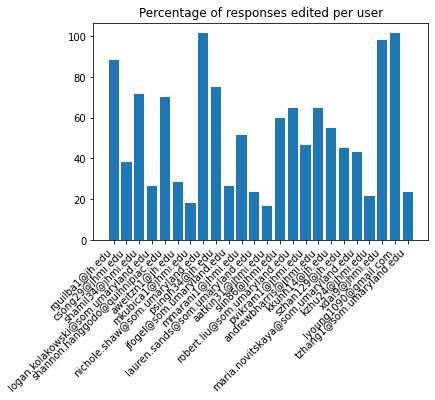

In [12]:
frac_edited_per_user = voice_edited_responses.apply(len) / num_voice_responses

print(f"Percentage of overall responses edited: {100 * frac_edited_per_user.mean():.2f}%")

plt.title('Percentage of responses edited per user')
plt.bar(finished_study_data['email'], frac_edited_per_user * 100)
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
# Study example response edits
voice_edited_responses[finished_study_data['email'] == 'andrewbharris@jhmi.edu'].squeeze()


,finished,modality,originalResponse,qid,score,started,userResponse,day,numInDay
0,2022-10-24 22:07:09.532000+00:00,voice,None,Pediatrics 25,0,2022-10-24 22:06:17.636000+00:00,osteotomies,0,0
1,2022-10-24 22:12:27.114000+00:00,voice,None,Recon 2,1,2022-10-24 22:11:59.180000+00:00,proximal tib-fib joint disruption,0,1
3,2022-10-24 22:16:48.583000+00:00,voice,decrease pull out strength increase Plus,Pediatrics 7,1,2022-10-24 22:16:29.192000+00:00,increased pull out strength,0,3
6,2022-10-24 22:19:40.781000+00:00,voice,genital scapula syndrome,Pediatrics 12,0,2022-10-24 22:19:21.747000+00:00,congenital scapula syndrome,0,6
31,2022-10-25 11:53:22.515000+00:00,voice,see the fascia play Bear Song.,Recon 19,1,2022-10-25 11:52:55.088000+00:00,Weightbearing as tolerated,1,12
32,2022-10-25 11:54:30.871000+00:00,voice,follow up with,Recon 17,1,2022-10-25 11:53:54.639000+00:00,follow up with hip precautions,1,13
34,2022-10-25 11:55:11.073000+00:00,voice,Aeropostale pleasure and hypotension,Trauma 14,0,2022-10-25 11:54:56.500000+00:00,Narrowed pulse pressure,1,15
36,2022-10-25 11:56:38.075000+00:00,voice,syrupy,Pediatrics 11,1,2022-10-25 11:56:25.194000+00:00,CRP,1,17
43,2022-10-26 15:36:25.999000+00:00,voice,None,Recon 28,1,2022-10-26 15:35:54.256000+00:00,anterior inferior,2,6
44,2022-10-26 15:36:34.012000+00:00,voice,None,Pediatrics 27,0,2022-10-26 15:36:28.188000+00:00,scoliosis,2,7


## Study Performance per Modality

[]

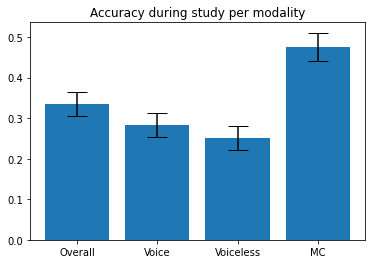

In [8]:
def calc_study_accuracy(qs, modality=None):
    if modality is not None:
        qs = qs[qs['modality'] == modality]
    return qs['score'].mean()

overall = finished_study_data['questionSchedule'].apply(lambda qs: calc_study_accuracy(qs)).mean()
voice = finished_study_data['questionSchedule'].apply(lambda qs: calc_study_accuracy(qs, 'voice')).mean()
voiceless = finished_study_data['questionSchedule'].apply(lambda qs: calc_study_accuracy(qs, 'voiceless')).mean()
mc = finished_study_data['questionSchedule'].apply(lambda qs: calc_study_accuracy(qs, 'mc')).mean()

sems = [finished_study_data['questionSchedule'].apply(lambda qs: calc_study_accuracy(qs, modality)).sem() for modality in [None, "voice", "voiceless", "mc"]]

plt.title('Accuracy during study per modality')
plt.bar(['Overall', 'Voice', 'Voiceless', 'MC'], [overall, voice, voiceless, mc], yerr=sems, alpha=1, ecolor='black', capsize=10)
plt.plot()


## Improvement per Modality

In [9]:
recall1 = pd.DataFrame(finished_post_data.iloc|[0]["first_posttest"]["A"])["automated_recall_score"]
recall2 = pd.DataFrame(finished_post_data.iloc[1]["first_posttest"]["A"])["automated_recall_score"]
recall1.to_numpy() == recall2.to_numpy()

<>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
<ipython-input-9-ea51b7c21a28>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  recall1 = pd.DataFrame(finished_post_data.iloc|[0]["first_posttest"]["A"])["automated_recall_score"]


TypeError: list indices must be integers or slices, not str

In [10]:
def calc_test_accuracies(test_type, modality, test_method):
    
    accs = []
    for _, row in finished_post_data.iterrows():
        qSched = row['questionSchedule']
        if modality == 'all':
            modality_qids = qSched['qid'].unique()
        else:
            modality_qids = qSched['qid'][qSched['modality'] == modality].unique()

        test = row[test_type.split(".")[0]]
        if "." in test_type:
            test = test[test_type.split(".")[1]]
        
        test = pd.DataFrame(test)
        if test_method == 'recognition':
            accuracy = np.mean([test['response'][i] == correct_answers[test['QID'][i]]
                                for i in range(len(test)) if test['QID'][i] in modality_qids])
        elif test_method == 'recall':
            accuracy = np.mean([test['automated_recall_score'][i]
                                for i in range(len(test)) if test['QID'][i] in modality_qids])
        
        accs.append(accuracy)
    
    return accs

pretest_acc = calc_test_accuracies('pretest', 'all', test_method="recognition")
posttest_recall_acc = []
posttest_recognition_acc = []

for posttest_iteration in ['first_posttest', 'second_posttest', 'posttest']:
    recall_testname = f'{posttest_iteration}.A'
    recog_testname = f'{posttest_iteration}.B'
    if posttest_iteration == "posttest":
        recall_testname = "posttestA"
        recog_testname = "posttestB"
    
    posttest_recall_acc.append({modality: calc_test_accuracies(recall_testname, modality, test_method='recall')
                                for modality in ['all', 'voice', 'voiceless', 'mc']})
    posttest_recognition_acc.append({modality: calc_test_accuracies(recog_testname, modality, test_method="recognition")
                                     for modality in ['all', 'voice', 'voiceless', 'mc']})



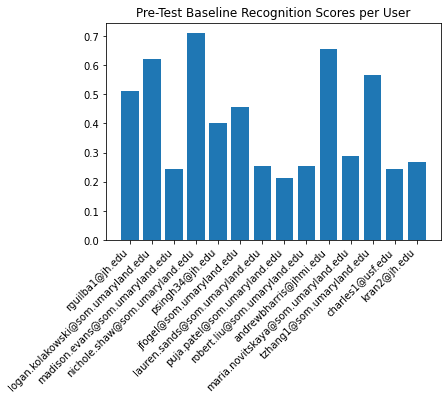

In [11]:
bar_width = 0.5
plt.title('Pre-Test Baseline Recognition Scores per User')
plt.bar(finished_post_data['email'], pretest_acc, alpha=1, ecolor='black', capsize=10)
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
print("Avg # of questions on post-test:", (1-np.mean(pretest_acc)) * 90)

Avg # of questions on post-test: 53.42857142857143


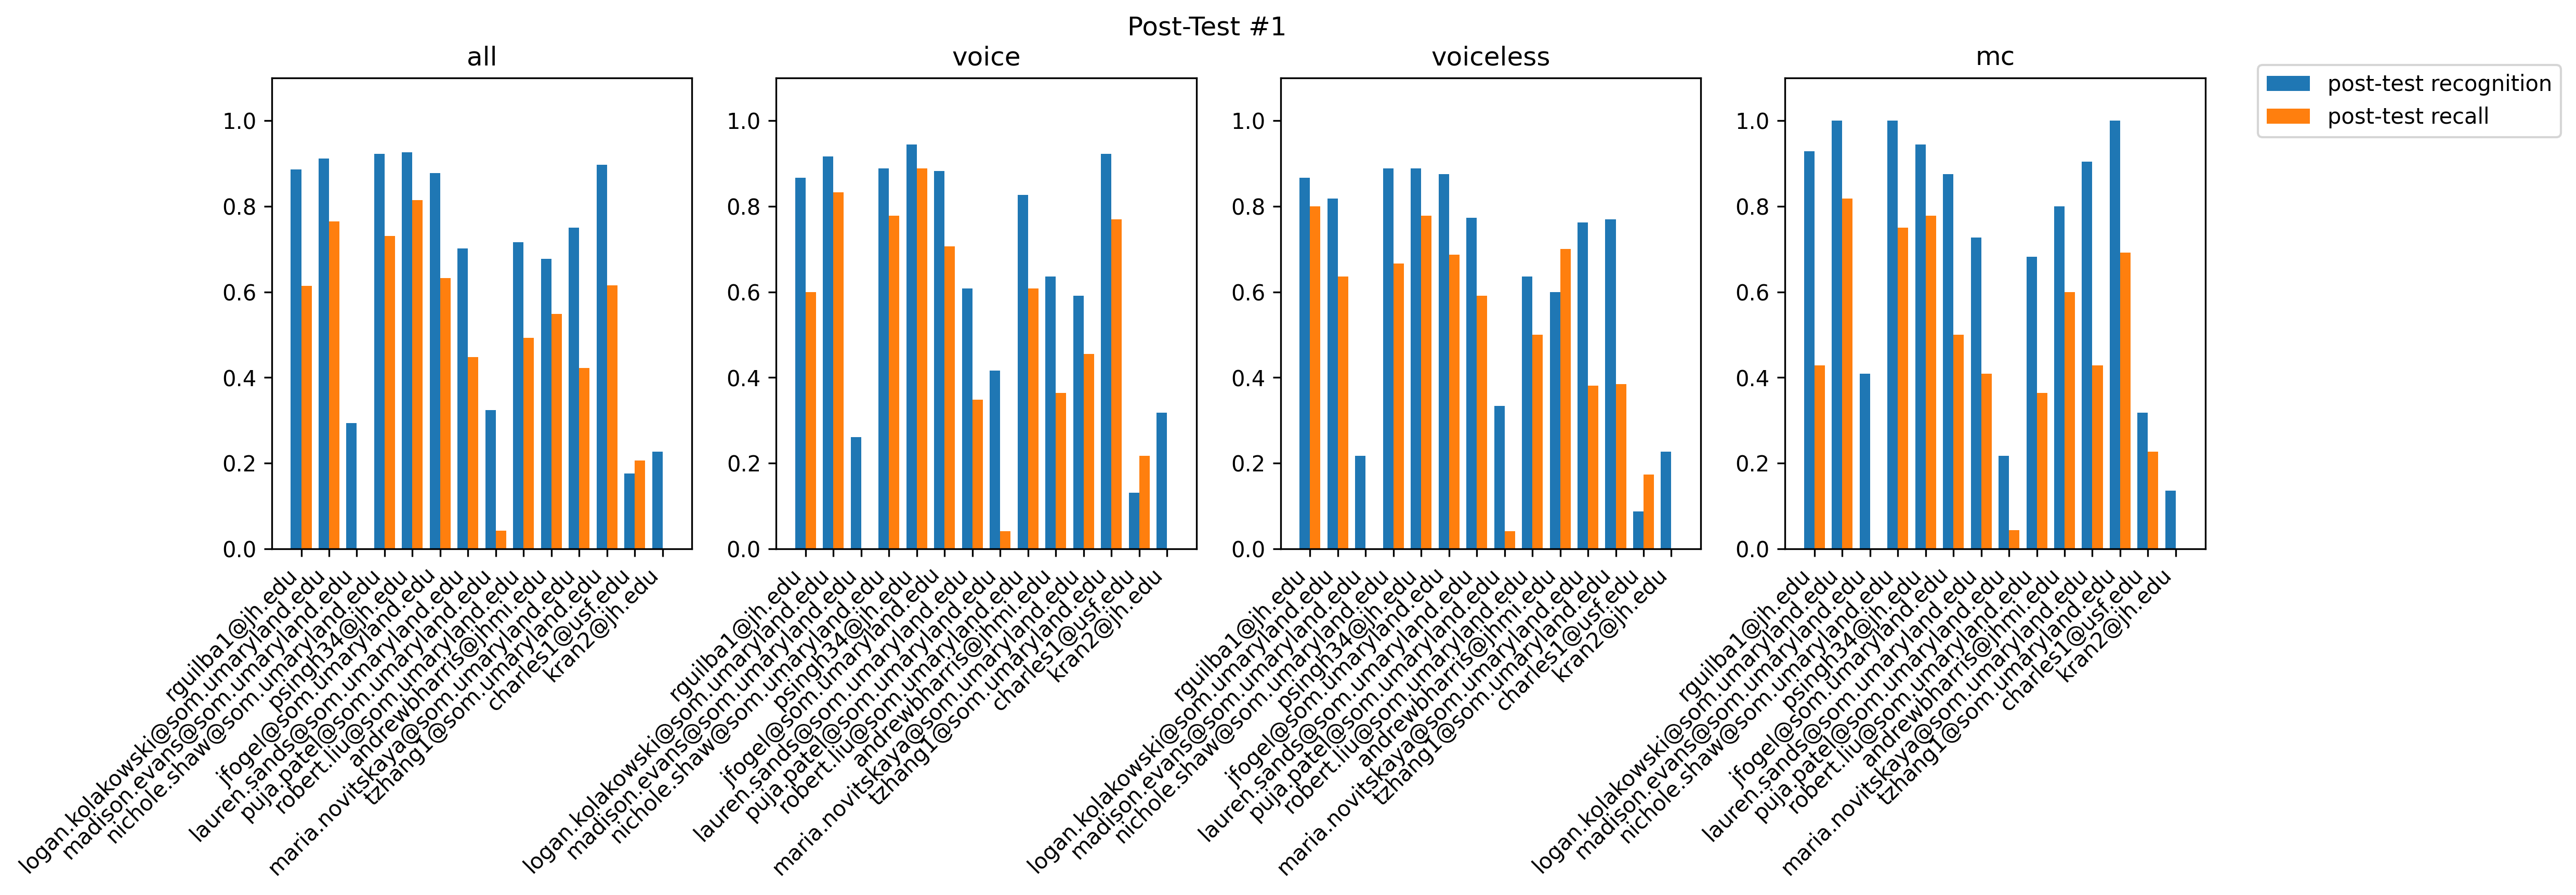

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
bar_width = 0.375
for i, modality in enumerate(['all', 'voice', 'voiceless', 'mc']):
    ax[i].set_title(f'{modality}')
    ax[i].set_ylim(0, 1.1)
    ax[i].bar(np.arange(len(finished_post_data)) + bar_width,
              posttest_recognition_acc[0][modality], width=bar_width, label='post-test recognition')
    ax[i].bar(np.arange(len(finished_post_data)) + (2 * bar_width),
              posttest_recall_acc[0][modality], width=bar_width, label='post-test recall')

    ax[i].set_xticks(np.arange(len(finished_post_data)) + 1.5 * bar_width,
                     finished_post_data['email'], rotation=45, ha='right')

plt.suptitle("Post-Test #1")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [18]:
# bar_width = 0.25
# mean_pretest_acc = {modality: np.mean(accs) for modality, accs in pretest_acc.items()}
# mean_posttest_recall_acc = {modality: np.mean(accs) for modality, accs in posttest_recall_acc.items()}
# mean_posttest_recognition_acc = {modality: np.mean(accs) for modality, accs in posttest_recognition_acc.items()}

# def print_dict(title, d):
#     print(f"{title}:")
#     for k, v in d.items():
#         print(f"  {k}: {v * 100:.2f}%")
# print_dict("Recall", mean_posttest_recall_acc)
# print_dict("Recognition", mean_posttest_recognition_acc)

# plt.figure(figsize=(8, 6))
# plt.bar(np.arange(4), mean_pretest_acc.values(), width=bar_width, label='pre-test recognition')
# plt.bar(np.arange(4) + bar_width, mean_posttest_recognition_acc.values(), width=bar_width, label='post-test recognition')
# plt.bar(np.arange(4) + 2 * bar_width, mean_posttest_recall_acc.values(), width=bar_width, label='post-test recall')
# plt.xticks(np.arange(4) + bar_width, mean_pretest_acc.keys())
# plt.legend()
# plt.show()

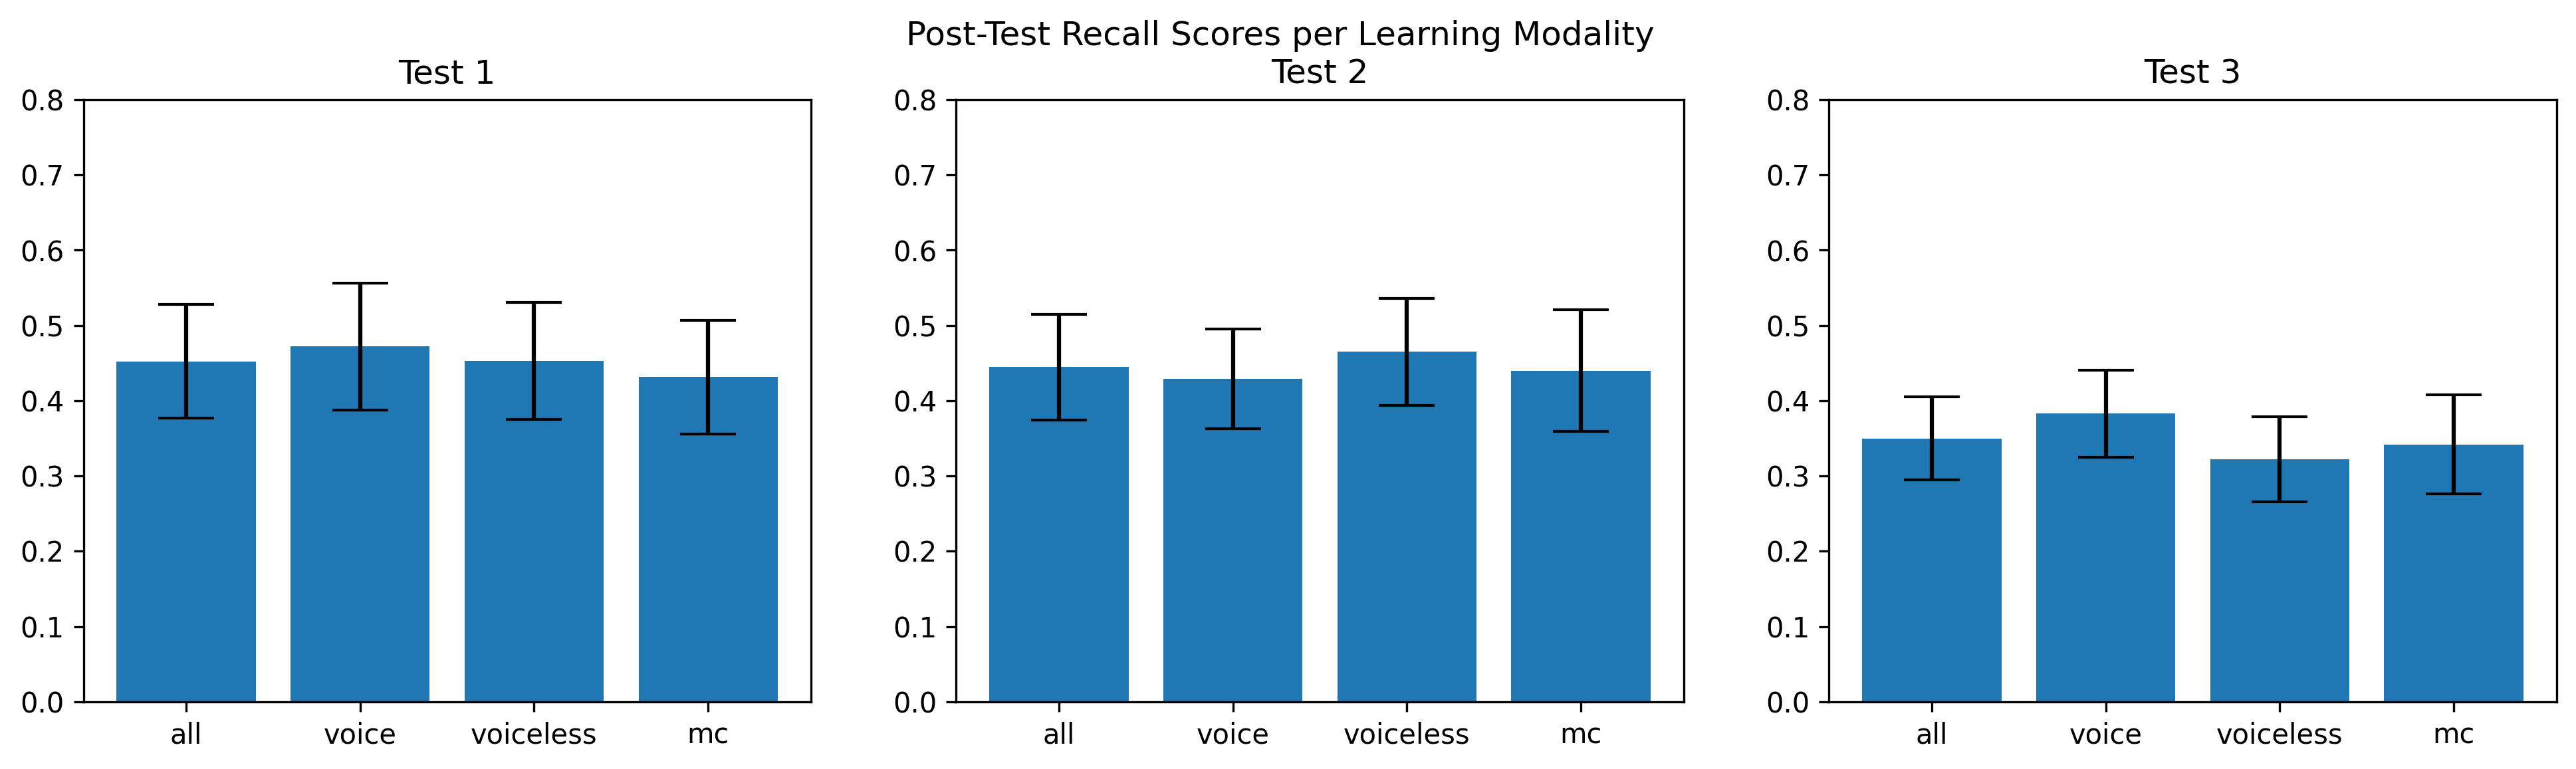

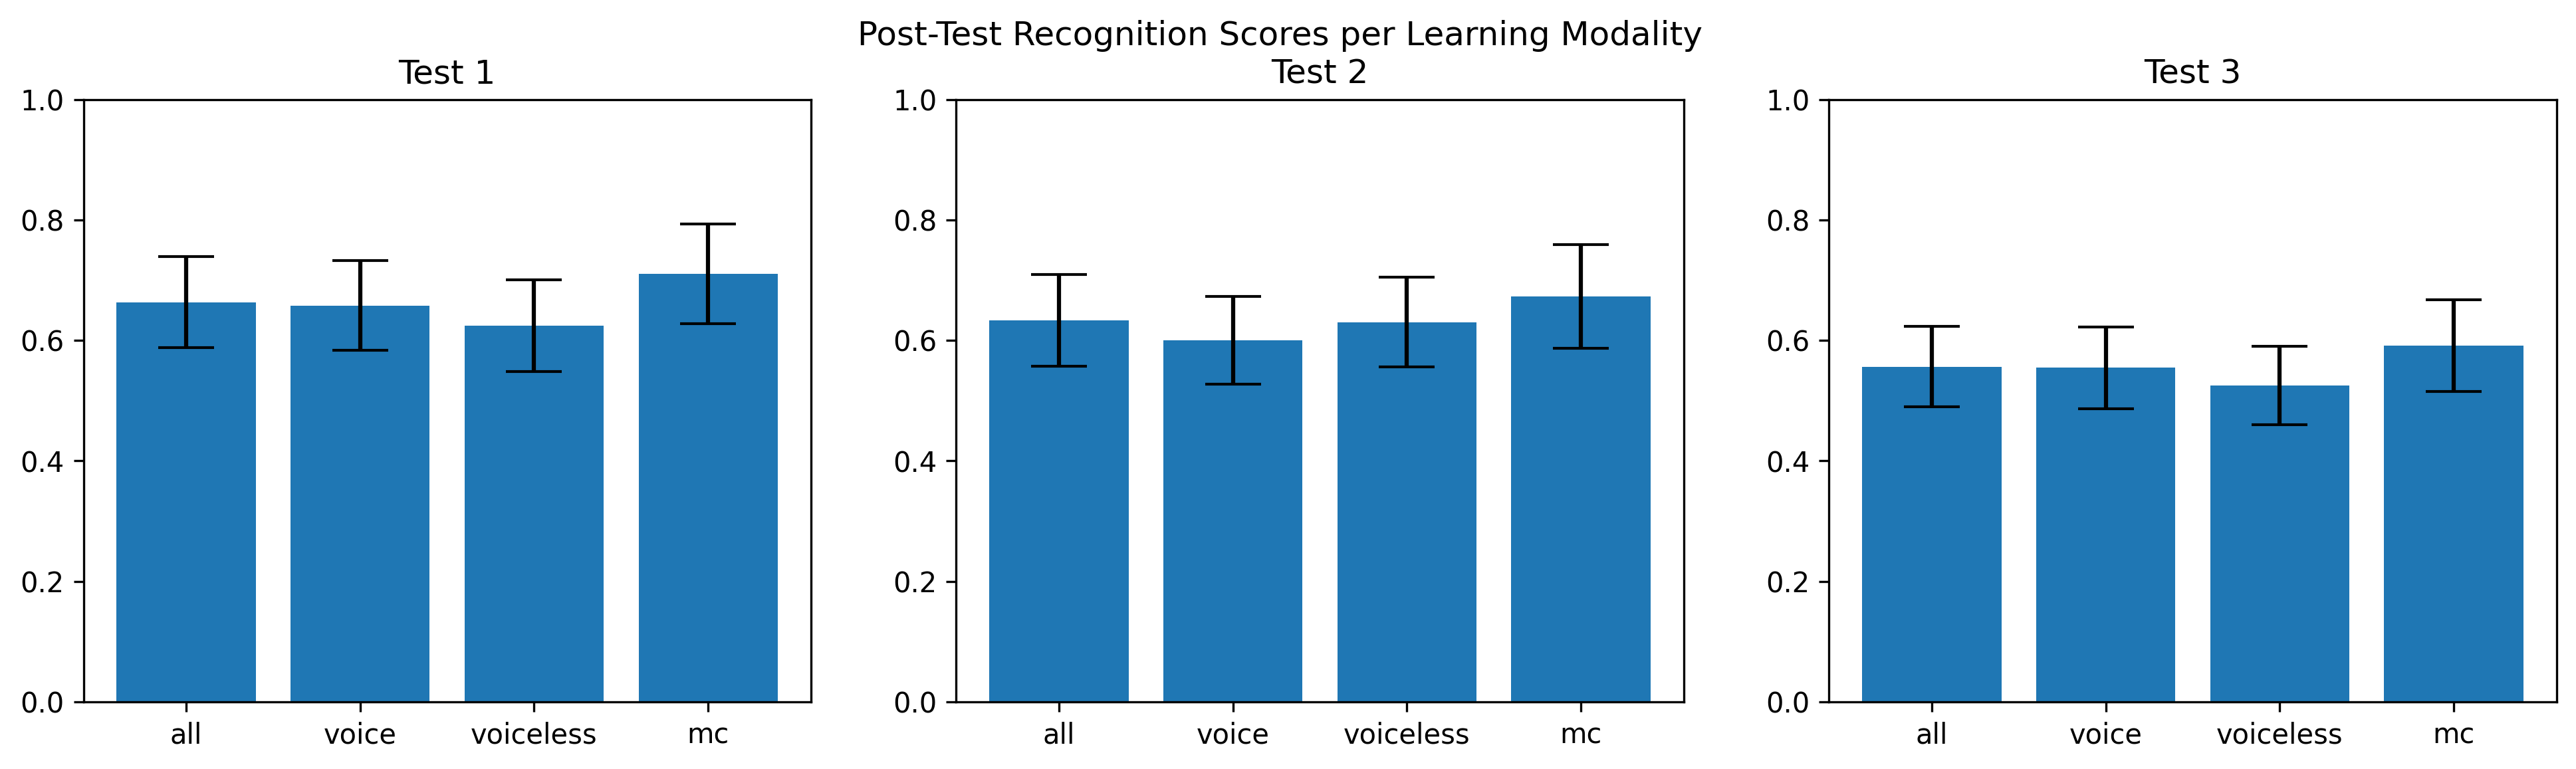

In [12]:
mean_posttest_recall_acc = [{modality: np.mean(accs) for modality, accs in posttest_recall_acc[i].items()} for i in range(3)] 
mean_posttest_recall_sem = [{modality: scipy.stats.sem(accs) for modality, accs in posttest_recall_acc[i].items()} for i in range(3)]
mean_posttest_recognition_acc = [{modality: np.mean(accs) for modality, accs in posttest_recognition_acc[i].items()} for i in range(3)]
mean_posttest_recognition_sem = [{modality: scipy.stats.sem(accs) for modality, accs in posttest_recognition_acc[i].items()} for i in range(3)]


fig, ax = plt.subplots(1, 3, figsize=(16, 4), dpi = 300)
for i in range(3):
  ax[i].bar(np.arange(4), mean_posttest_recall_acc[i].values(), yerr=mean_posttest_recall_sem[i].values(), alpha=1, ecolor='black', capsize=10)
  ax[i].axis(ymin=0, ymax=0.8)
  ax[i].set_xticks(np.arange(4), mean_posttest_recall_acc[i].keys())
  ax[i].set_title(f"Test {i + 1}")

fig.suptitle('Post-Test Recall Scores per Learning Modality')
fig.show()


fig, ax = plt.subplots(1, 3, figsize=(16, 4), dpi = 300)
for i in range(3):
  ax[i].bar(np.arange(4), mean_posttest_recognition_acc[i].values(), yerr=mean_posttest_recognition_sem[i].values(), alpha=1, ecolor='black', capsize=10)
  ax[i].axis(ymin=0, ymax=1)
  ax[i].set_xticks(np.arange(4), mean_posttest_recognition_acc[i].keys())
  ax[i].set_title(f"Test {i + 1}")

fig.suptitle('Post-Test Recognition Scores per Learning Modality')
fig.show()

Recall Test 1
all p-value: 0.0009240161485984675
voice p-value: 0.0009240161485984675
voiceless p-value: 0.0009240161485984675
mc p-value: 0.0009240161485984675
Recall Test 2
all p-value: 0.000764131055591192
voice p-value: 0.0009240161485984675
voiceless p-value: 0.0009240161485984675
mc p-value: 0.0009240161485984675
Recall Test 3
all p-value: 0.0007703340507141782
voice p-value: 0.0009240161485984675
voiceless p-value: 0.0009240161485984675
mc p-value: 0.0009240161485984675
Recognition Test 1
all p-value: 7.865598099758966e-05
voice p-value: 0.000155374931653522
voiceless p-value: 0.00028842793298249357
mc p-value: 0.00014254255335907322
Recognition Test 2
all p-value: 0.0001141328196614447
voice p-value: 0.000155374931653522
voiceless p-value: 8.174359830707125e-05
mc p-value: 0.0002729260821466354
Recognition Test 3
all p-value: 9.804122371593677e-05
voice p-value: 8.174359830707125e-05
voiceless p-value: 0.00028842793298249357
mc p-value: 0.000155374931653522


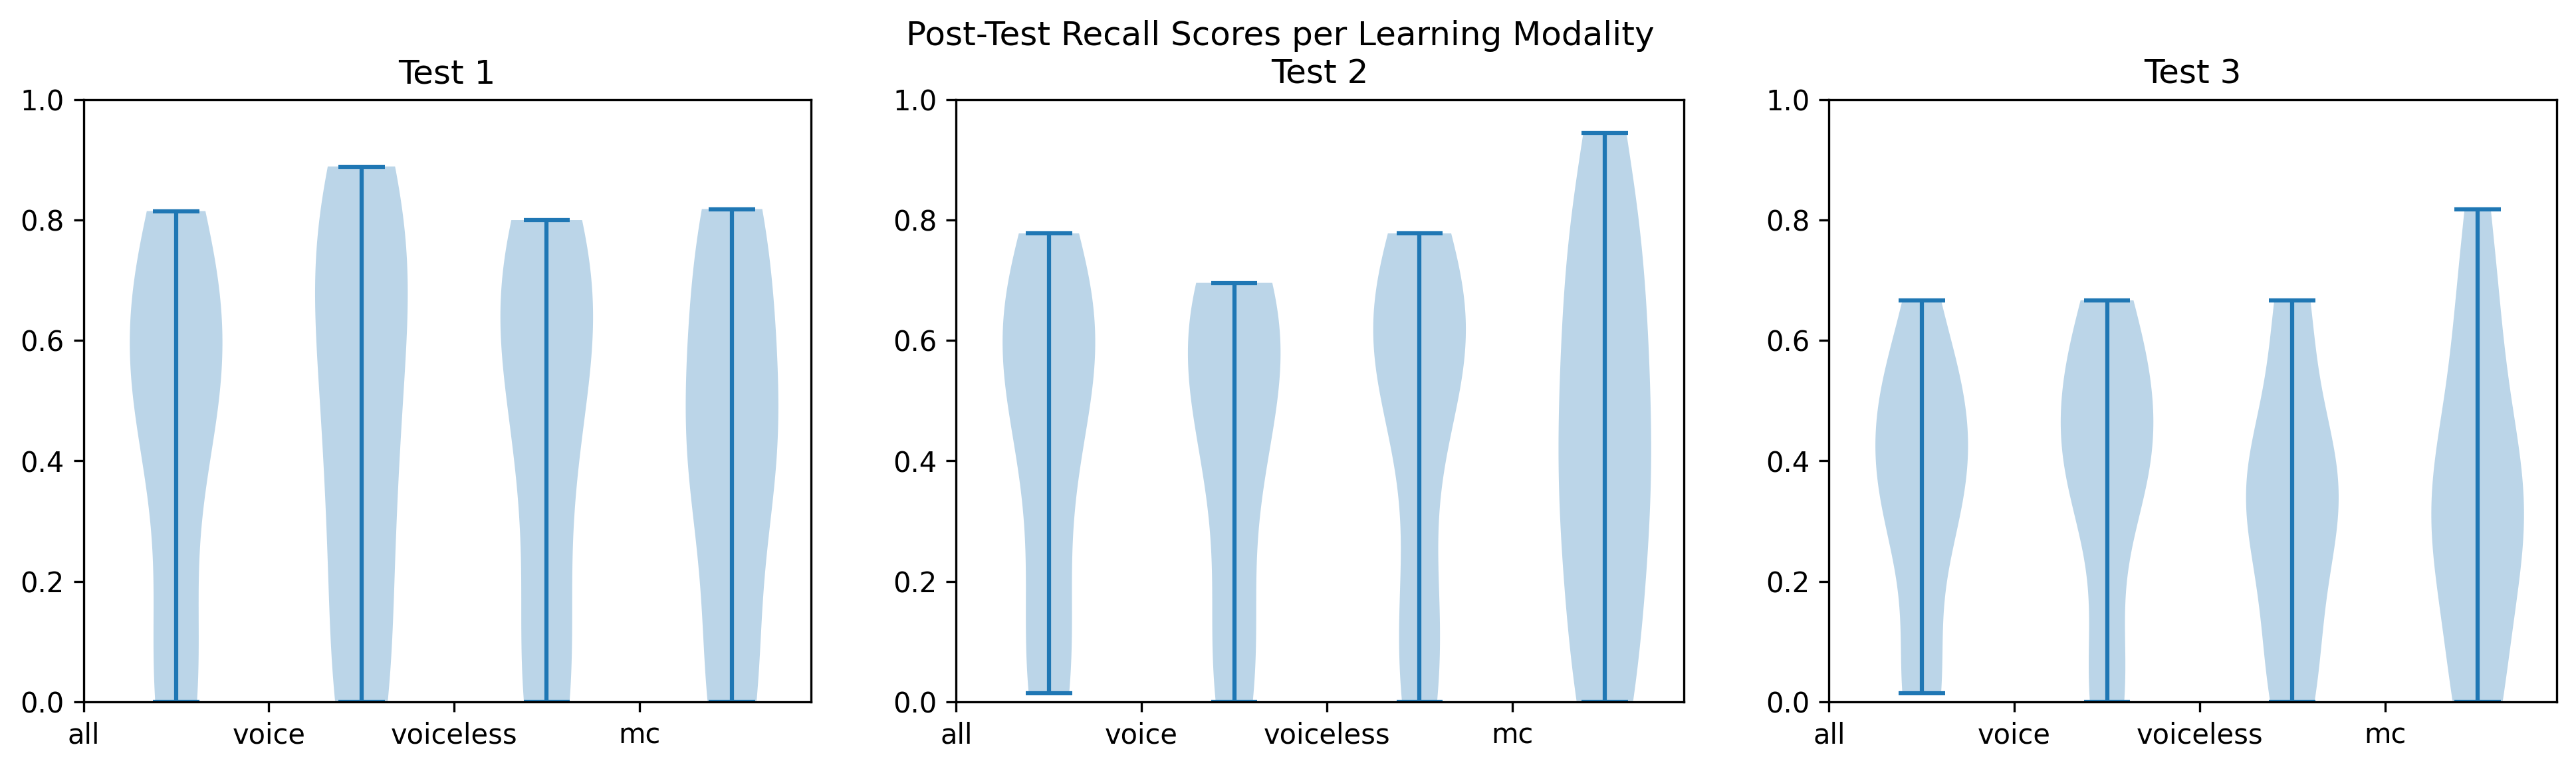

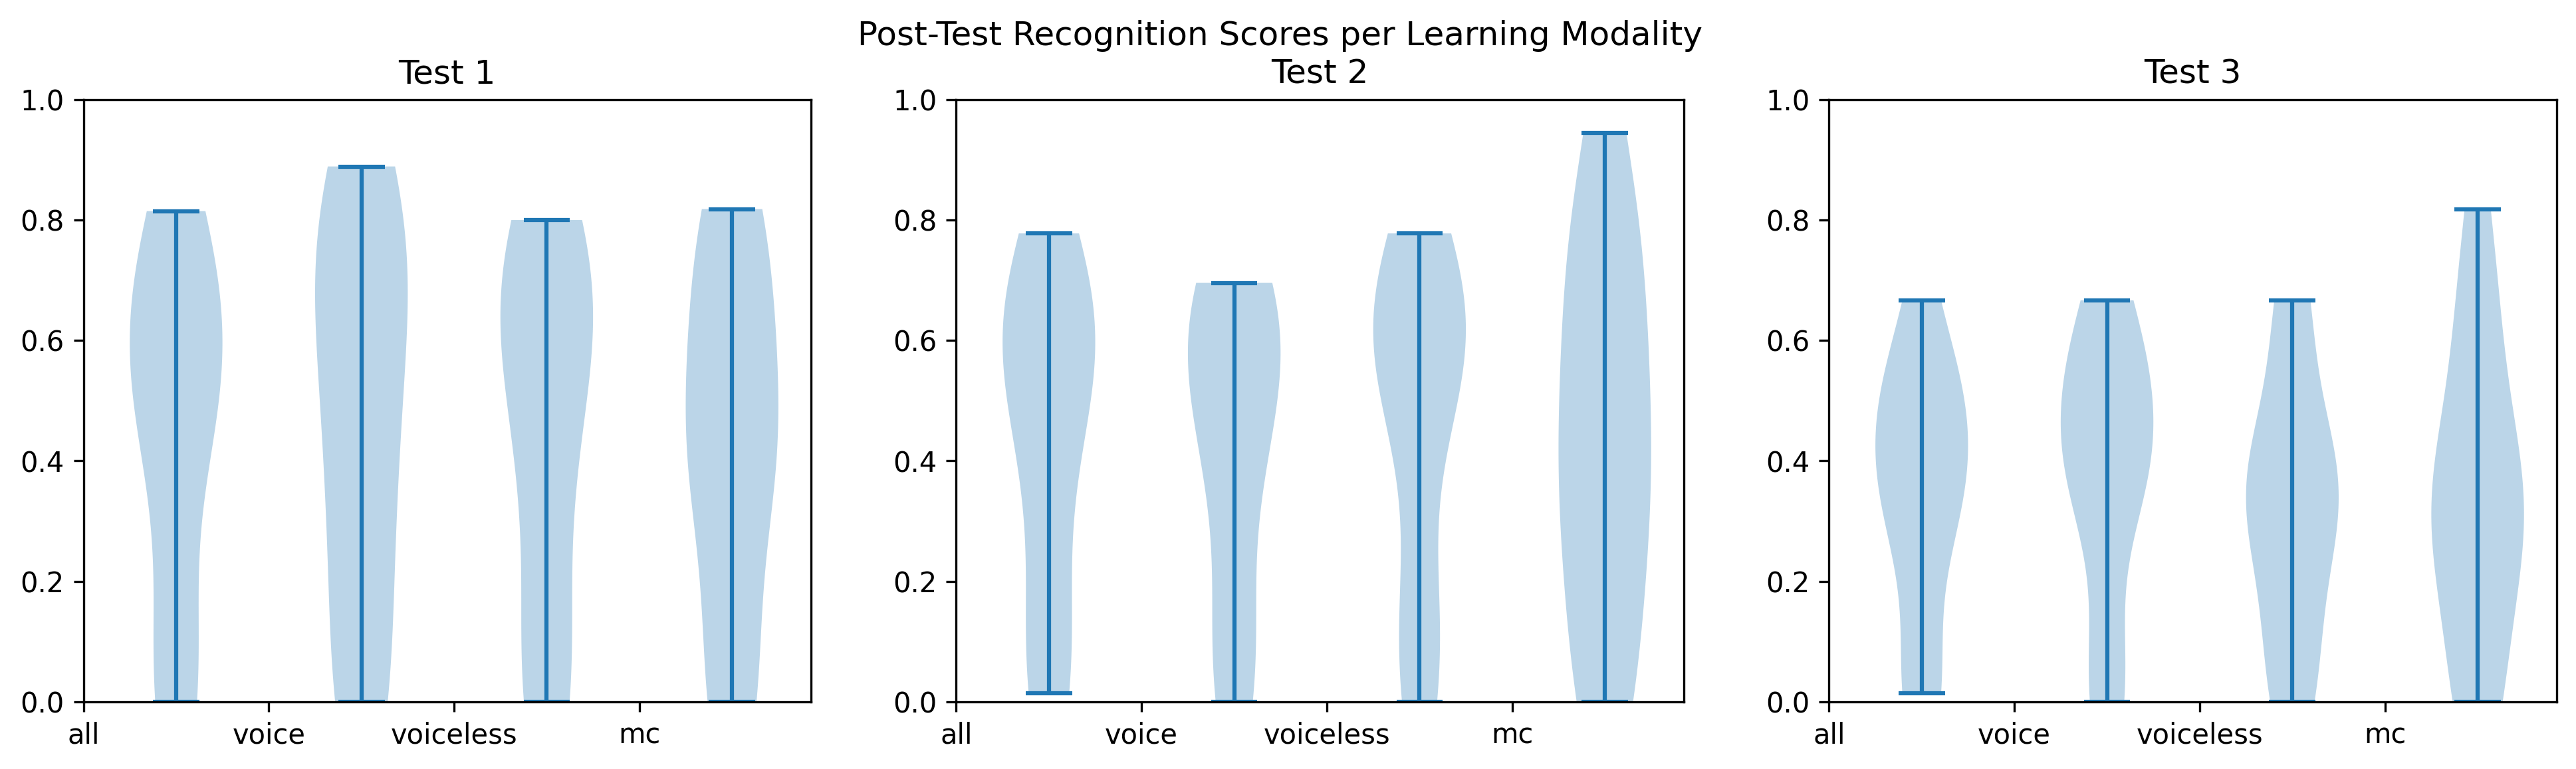

In [38]:
import seaborn as sns

mean_posttest_recall_acc = [{modality: np.mean(accs) for modality, accs in posttest_recall_acc[i].items()} for i in range(3)] 
mean_posttest_recall_sem = [{modality: scipy.stats.sem(accs) for modality, accs in posttest_recall_acc[i].items()} for i in range(3)]
mean_posttest_recognition_acc = [{modality: np.mean(accs) for modality, accs in posttest_recognition_acc[i].items()} for i in range(3)]
mean_posttest_recognition_sem = [{modality: scipy.stats.sem(accs) for modality, accs in posttest_recognition_acc[i].items()} for i in range(3)]


fig, ax = plt.subplots(1, 3, figsize=(16, 4), dpi = 300)
for i in range(3):
  ax[i].violinplot([accs for _, accs in posttest_recall_acc[i].items()])
  ax[i].axis(ymin=0, ymax=1)
  ax[i].set_xticks(np.arange(4) + 0.5, mean_posttest_recall_acc[i].keys())
  ax[i].set_title(f"Test {i + 1}")

fig.align_xlabels()
fig.suptitle('Post-Test Recall Scores per Learning Modality')
fig.show()

fig, ax = plt.subplots(1, 3, figsize=(16, 4), dpi = 300)
for i in range(3):
  ax[i].violinplot([accs for _, accs in posttest_recall_acc[i].items()])
  ax[i].axis(ymin=0, ymax=1)
  ax[i].set_xticks(np.arange(4) + 0.5, mean_posttest_recognition_acc[i].keys())
  ax[i].set_title(f"Test {i + 1}")
fig.suptitle('Post-Test Recognition Scores per Learning Modality')
fig.show()


for i in range(3):
  print(f"Recall Test {i + 1}")
  for key, accs in posttest_recall_acc[i].items():
    ks_result = (scipy.stats.kstest(accs, cdf='norm'))
    # print(f"{key} K-S statistic: {ks_result[0]}")
    print(f"{key} p-value: {ks_result[1]}")

for i in range(3):
  print(f"Recognition Test {i + 1}")
  for key, accs in posttest_recognition_acc[i].items():
    ks_result = (scipy.stats.kstest(accs, cdf='norm'))
    # print(f"{key} K-S statistic: {ks_result[0]}")
    print(f"{key} p-value: {ks_result[1]}")



In [8]:
# Create list of all post-test recall responses
qs = []
for i in range(len(finished_post_data)):
    for q in finished_post_data["first_posttest"][i]["A"]:
        qs.append((q, finished_post_data["email"][i]))

    for q in finished_post_data["second_posttest"][i]["A"]:
        qs.append((q, finished_post_data["email"][i]))

    for q in finished_post_data["posttestA"][i].to_dict("records"):
        qs.append((q, finished_post_data["email"][i]))

In [29]:
# Combine duplicate responses
def similar(q1, q2):
    return q1['QID'] == q2['QID'] and q1['response'] == q2['response']

edges = []
for i in range(len(qs)):
    for j in range(i + 1, len(qs)):
        if similar(qs[i][0], qs[j][0]):
            edges.append((i, j))

g = nx.Graph(edges)
clustered_qs = [[qs[i] for i in group] for group in nx.connected_components(g)]
print(f"Original questions: {len(qs)}, reduced questions: {len(clustered_qs)}")
print(f"{len(qs) / len(clustered_qs):.2f}x reduction in questions to grade!")

Original questions: 4827, reduced questions: 796
6.06x reduction in questions to grade!


In [14]:
clustered_qs[30]

[({'QID': 'Pediatrics 21',
   'automated_recall_score': 1,
   'finish': datetime.datetime(2022, 11, 13, 22, 47, 24, 100000, tzinfo=datetime.timezone.utc),
   'response': 'bracing',
   'start': datetime.datetime(2022, 11, 13, 22, 47, 17, 517000, tzinfo=datetime.timezone.utc)},
  'andrewbharris@jhmi.edu'),
 ({'QID': 'Pediatrics 21',
   'automated_recall_score': 1,
   'finish': datetime.datetime(2023, 1, 21, 2, 59, 18, 848000, tzinfo=datetime.timezone.utc),
   'response': 'bracing',
   'start': datetime.datetime(2023, 1, 21, 2, 59, 2, 956000, tzinfo=datetime.timezone.utc)},
  'rguilba1@jh.edu'),
 ({'QID': 'Pediatrics 21',
   'automated_recall_score': 1,
   'finish': datetime.datetime(2023, 2, 13, 13, 44, 3, 525000, tzinfo=datetime.timezone.utc),
   'response': 'bracing',
   'start': datetime.datetime(2023, 2, 13, 13, 43, 58, 581000, tzinfo=datetime.timezone.utc)},
  'shannon.hanggodo@quinnipiac.edu'),
 ({'QID': 'Pediatrics 21',
   'automated_recall_score': 1,
   'finish': datetime.datetim

In [15]:
import docx

def add_question(q_group, document):
    q = q_group[0][0]
    document.add_paragraph(f"QID: {q['QID']}")

    topic = ' '.join(q["QID"].split(' ')[:-1])
    figs = all_qs["Figures"][all_qs["Id"] == q["QID"]].item()
    if isinstance(figs, list):
        for f in figs:
            document.add_picture(f"../questions/topics/{topic}/{f}", height=docx.shared.Inches(2))

    document.add_paragraph(f"Question: {all_qs['Question'][all_qs['Id'] == q['QID']].item()}")
    document.add_paragraph(f"User Response: {q['response']}")
    document.add_paragraph(f"Correct Response: {all_qs['MultipleChoice'][all_qs['Id'] == q['QID']].item()['Correct']}")
    document.add_paragraph("Was User Correct?: ")
    document.add_paragraph("Comments: ")
    document.add_paragraph(f"SAIL Score: {q['automated_recall_score']}")
    document.add_paragraph(f"Users: {', '.join([q[1] for q in q_group])}")
    document.add_page_break()

In [16]:
# Write document for posttest questions
np.random.default_rng(42).shuffle(clustered_qs)

document = docx.Document()
for q_group in tqdm.tqdm(clustered_qs):
    add_question(q_group, document)
document.save("posttest_answers_to_grade.docx")

/home/arpan/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
100%|██████████| 796/796 [00:08<00:00, 96.29it/s] 


## Forgetting Curve

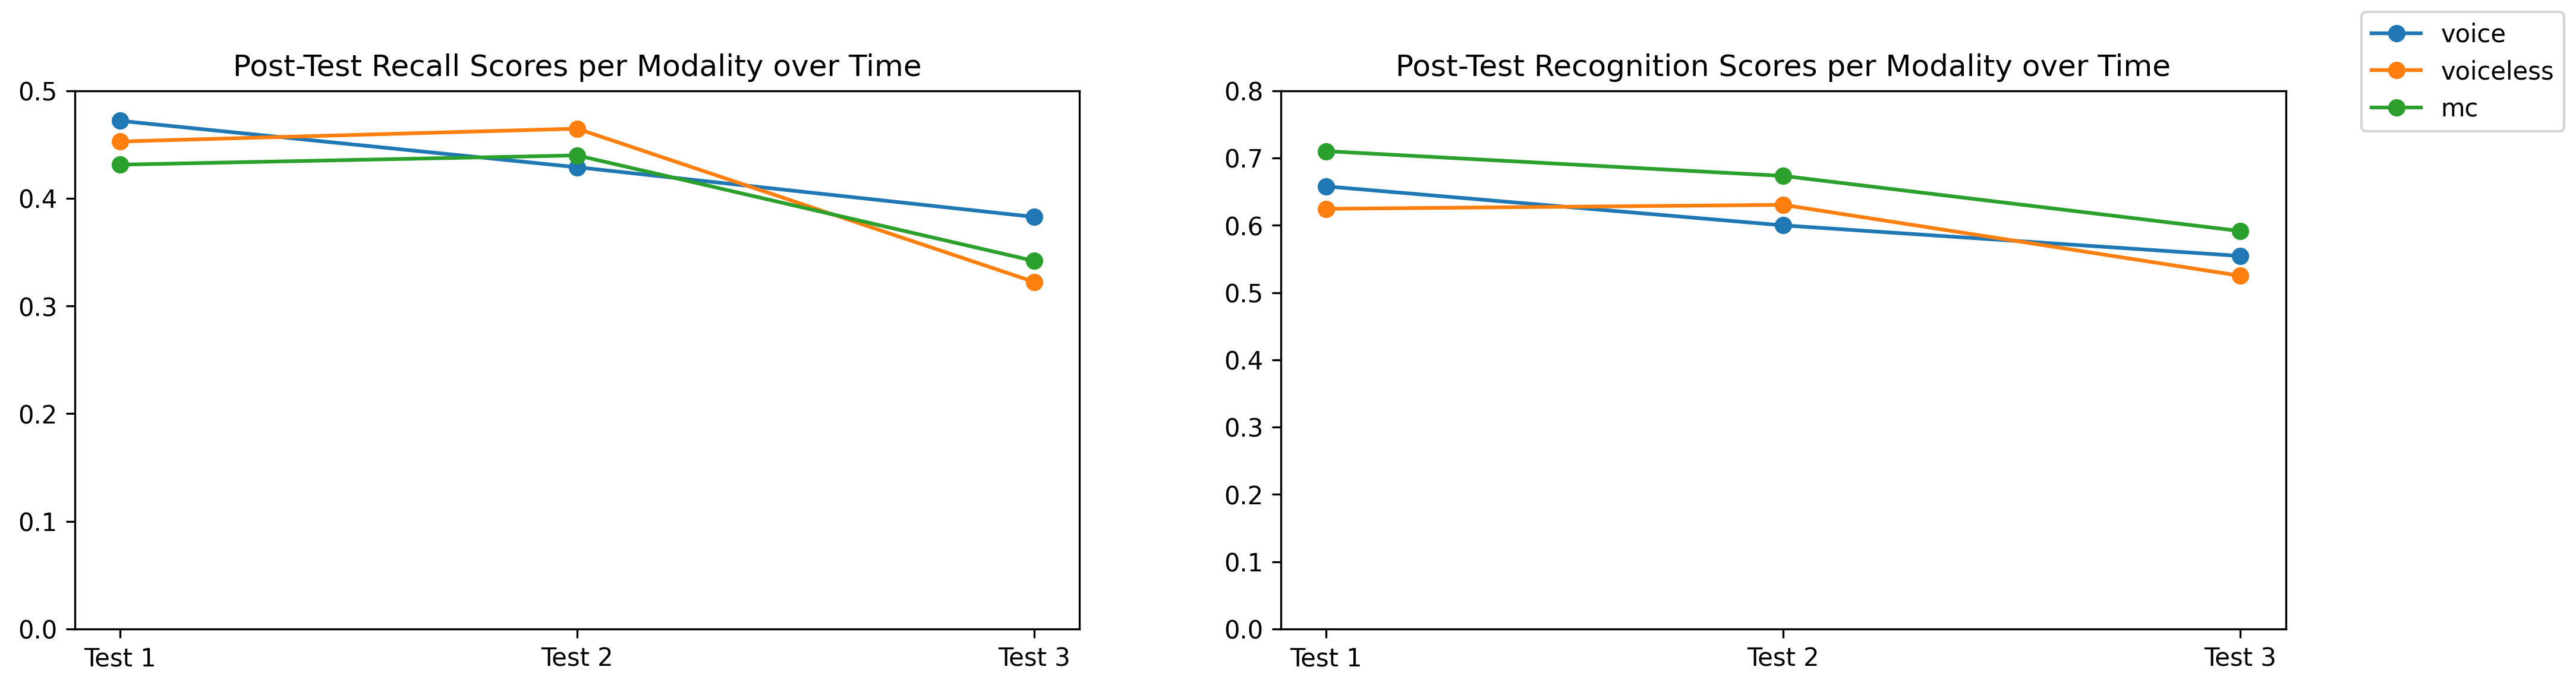

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4), dpi = 300)
modalities = ['voice', 'voiceless', 'mc']

for modality in modalities:
  ax[0].errorbar(['Test 1', 'Test 2', 'Test 3'], 
                 [mean_posttest_recall_acc[i][modality] for i in range(3)], 
                #  yerr=[mean_posttest_recall_sem[i][modality] for i in range(3)], 
                 fmt='o-', label=modality)
ax[0].axis(ymin=0, ymax=0.5)
ax[0].set_title("Post-Test Recall Scores per Modality over Time")

for modality in modalities:
  ax[1].errorbar(['Test 1', 'Test 2', 'Test 3'], 
                 [mean_posttest_recognition_acc[i][modality] for i in range(3)], 
                #  yerr=[mean_posttest_recognition_sem[i][modality] for i in range(3)], 
                 fmt='o-')
ax[1].set_xticks(np.arange(3), ['Test 1', 'Test 2', 'Test 3'])
ax[1].axis(ymin=0, ymax=0.8)
ax[1].set_title("Post-Test Recognition Scores per Modality over Time")

fig.legend()
fig.show()
fig.savefig('forgetting_curve_axis=0.png', facecolor='white')

## Automatic Free Response Grading

In [42]:
import os
import sys

sys.path.append(os.path.abspath('../backend/scoring'))

In [43]:
import score

scorer = score.new_scorer(root='../backend/scoring', verbose=False)

/home/arpan/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [44]:
for i in tqdm.trange(len(finished_post_data)):
    for posttest_iteration in ['first_posttest', 'second_posttest', "posttestA"]:
        if posttest_iteration == "posttestA":
            posttestA = finished_post_data.iloc[i][posttest_iteration]
        else:
            posttestA = finished_post_data.iloc[i][posttest_iteration]['A']
        
        # if posttest_iteration == "posttestA":
        #     print(posttestA.iloc[0]['start'])
        for j in range(len(posttestA)):
            if posttest_iteration == "posttestA":
                # print(posttestA.iloc[j])
                posttestA.at[j, "automated_recall_score"] = scorer.score(posttestA.iloc[j]['QID'], posttestA.iloc[j]["response"])
                pass
            else: 
                posttestA[j]["automated_recall_score"] = scorer.score(posttestA[j]['QID'], posttestA[j]["response"])

In [46]:
pd.DataFrame(finished_post_data["posttestA"][2])

,QID,automated_recall_score,finish,response,start
0,Trauma 6,0,2023-04-11 02:41:06.686000+00:00,i dont know,2023-04-11 02:40:23.822000+00:00
1,Trauma 7,0,2023-04-11 02:41:50.643000+00:00,mri,2023-04-11 02:41:07.916000+00:00
2,Trauma 30,0,2023-04-11 02:42:03.521000+00:00,type iii,2023-04-11 02:41:51.697000+00:00
3,Recon 26,0,2023-04-11 02:42:12.152000+00:00,i dont know,2023-04-11 02:42:04.557000+00:00
4,Pediatrics 11,1,2023-04-11 02:42:18.414000+00:00,esr,2023-04-11 02:42:13.059000+00:00
5,Recon 12,0,2023-04-11 02:42:28.434000+00:00,i dont know,2023-04-11 02:42:19.622000+00:00
6,Trauma 19,0,2023-04-11 02:42:43.010000+00:00,i dont know,2023-04-11 02:42:29.273000+00:00
7,Pediatrics 1,0,2023-04-11 02:42:57.285000+00:00,i dont know,2023-04-11 02:42:43.906000+00:00
8,Pediatrics 6,0,2023-04-11 02:43:05.852000+00:00,i dont know,2023-04-11 02:42:58.122000+00:00
9,Pediatrics 17,0,2023-04-11 02:43:14.692000+00:00,vitamin d,2023-04-11 02:43:06.765000+00:00


In [47]:
pd.DataFrame(finished_post_data["first_posttest"][0]["A"])

,QID,automated_recall_score,finish,response,start
0,Pediatrics 23,1,2023-01-13 13:19:49.992000+00:00,Observation,2023-01-13 13:19:42.242000+00:00
1,Pediatrics 9,1,2023-01-13 13:20:00.103000+00:00,Rib vertebral angle,2023-01-13 13:19:50.920000+00:00
2,Trauma 17,1,2023-01-13 13:20:11.380000+00:00,Tuberosity malposition,2023-01-13 13:20:01.464000+00:00
3,Recon 12,1,2023-01-13 13:20:30.937000+00:00,Irrigation and debridement with intraoperative...,2023-01-13 13:20:12.740000+00:00
4,Recon 30,1,2023-01-13 13:20:49.056000+00:00,Femoral component anterior translation during ...,2023-01-13 13:20:31.863000+00:00
5,Trauma 7,1,2023-01-13 13:20:58.013000+00:00,Intraoperative fluoroscopy,2023-01-13 13:20:50.096000+00:00
6,Pediatrics 24,1,2023-01-13 13:21:08.499000+00:00,Left sided hypoplasia,2023-01-13 13:20:58.972000+00:00
7,Recon 28,0,2023-01-13 13:21:18.936000+00:00,Anterior inferior quadrant,2023-01-13 13:21:09.767000+00:00
8,Recon 11,0,2023-01-13 13:21:45.219000+00:00,"Reduced ductility/fragility, Increased strength",2023-01-13 13:21:19.742000+00:00
9,Recon 10,0,2023-01-13 13:21:54.493000+00:00,Reduced ductility,2023-01-13 13:21:46.128000+00:00


In [48]:
for posttest_iteration in ['posttestA', 'first_posttest', 'second_posttest']:
    print(f"Writing scores for {posttest_iteration}")
    for email, posttest in tqdm.tqdm(list(zip(finished_post_data['email'], finished_post_data[posttest_iteration]))):
        with open(f'../backend/users/{email}.yaml') as f:
            user_data = yaml.safe_load(f)
        
        if posttest_iteration != "posttestA": 
            for q, posttest_q in zip(user_data[posttest_iteration]["A"], posttest["A"]):
                q['automated_recall_score'] = posttest_q["automated_recall_score"]
        else:
            posttest_array = [posttest.iloc[i].to_dict() for i in range(posttest.shape[0])]
            for q, posttest_q in zip(user_data[posttest_iteration], posttest_array):
                q['automated_recall_score'] = int(posttest_q["automated_recall_score"])
        
        with open(f'../backend/users/{email}.yaml', 'w') as f:
            yaml.dump(user_data, f)

  0%|          | 0/27 [00:00<?, ?it/s]

Scoring posttestA


  0%|          | 0/27 [00:00<?, ?it/s]

Scoring first_posttest


  0%|          | 0/27 [00:00<?, ?it/s]

Scoring second_posttest


100%|██████████| 27/27 [00:25<00:00,  1.08it/s]


## Question Difficulties

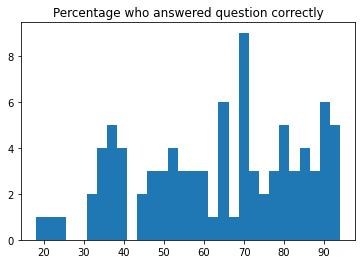

In [7]:
question_difficulties = pd.read_csv('question_difficulties.csv')
plt.title('Percentage who answered question correctly')
plt.hist(question_difficulties['Percent who answered correctly'], bins=30)
plt.show()

## Sleep Data

In [90]:
finished_post_data['sleepData'].to_numpy()

array([array([ 8., 10., 10., 10., 10.,  8.,  7.,  8.,  6.,  8.]),
       array([5., 6., 5., 5., 3., 6.]),
       array([8., 8., 8., 7., 7., 8., 6., 8., 7., 8.]),
       array([6. , 6. , 5.5, 6. , 7. , 7. , 7. , 7. , 7. ]),
       array([9., 6., 6., 7., 6., 6., 9., 9., 6., 7.]),
       array([6., 7., 7., 6., 7., 5., 8., 7., 5., 8.]),
       array([6.5, 7. , 8. , 7. , 5.5, 7. , 6.5, 7. , 7. , 6. ]),
       array([7. , 8. , 7. , 8. , 8. , 7.5, 7. , 7. , 7. , 8. ]),
       array([7., 4., 8., 6., 6., 8., 8., 5., 6., 6.])], dtype=object)